In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import os
# import tensorflow.contrib.slim as slim
import sys
from tensorflow import keras
import time
import datetime
import cv2

/home/aditya/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aditya/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aditya/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aditya/anaconda3/envs/tf/lib/python3.7/site-packages

In [2]:
sys.path.append('../')

In [3]:
import anchors as Anchors
import backbone as Backbone
import model as Model
import dataprocess as DataHandler
import loss as Losses
import generator as Generator

In [4]:
# from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# loading dataset

In [5]:
train_loc = "../../dataset/train_split_images/"
annotations_loc = "../../dataset/annotations/"
test_loc = "../../dataset/test_split_images/"
image_folder_path = "../../dataset/Wider/WIDER_train/images/"
label_path = "../../dataset/Wider/wider_face_split/wider_face_train_bbx_gt.txt"
cropped_wider = "../../dataset/Wider_cropped/train_images/"
cropped_annotations = "../../dataset/Wider_cropped/ground_truth.txt"

In [6]:
mData = DataHandler.maviData(test_loc,annotations_loc)
# mData = DataHandler.maviData(train_loc,annotations_loc)
# mData = DataHandler.WiderDataset(image_folder_path,label_path)
# mData = DataHandler.WiderDataset(cropped_wider,cropped_annotations)

In [7]:
len(mData.data)

324

In [8]:
mData.data[0]

{'path': '../../dataset/test_split_images/2019-06-17 15_01_25__018426__44841b92-90d1-11e9-8b8d-dd1eda89fb93.jpg',
 'bbox': [(447, 156, 49, 59)]}

# loading model

In [9]:
## REtinaFAce shallower layers
anchors_cfg = {}
# anchors_cfg[0] = {'base_size':32,'ratios':[1,1.5],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':8}
# anchors_cfg[1] = {'base_size':64,'ratios':[1,1.5],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':16}
# anchors_cfg[2] = {'base_size':128,'ratios':[1,1.5],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':32}
# anchors_cfg[3] = {'base_size':256,'ratios':[1,1.5],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':64}
# anchors_cfg[4] = {'base_size':512,'ratios':[1,1.5],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':128}
anchors_cfg[0] = {'base_size':16,'ratios':[1],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':4}
anchors_cfg[1] = {'base_size':32,'ratios':[1],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':8}
anchors_cfg[2] = {'base_size':64,'ratios':[1],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':16}
anchors_cfg[3] = {'base_size':128,'ratios':[1],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':32}
anchors_cfg[4] = {'base_size':256,'ratios':[1],'scales':np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),'stride':64}

input_shape = (480,640,3)#(480,640,3)
# input_shape = (640,640,3)

In [10]:
# model = Model.resnet50_retinanet(input_shape=input_shape,anchors_cfg=anchors_cfg,separate_evaluators=True)
# model = Model.resnet50_retinanet_bbox(input_shape=input_shape,anchors_cfg=anchors_cfg)
model = Model.resnet50_retinanet_bbox(input_shape=input_shape,anchors_cfg=anchors_cfg,separate_evaluators=True,context=True,image_shape=(480,640))

/home/aditya/anaconda3/envs/tf/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
x3_64 shape (?, ?, ?, 64)
x3_64 shape (?, ?, ?, 64)
x3_64 shape (?, ?, ?, 64)
x3_64 shape (?, ?, ?, 64)
x3_64 shape (?, ?, ?, 64)
[<tf.Tensor 'out/concat:0' shape=(?, ?, 5) dtype=float32>]
(1, 76740, 4)
bx1 shape:  (?, 76740)
bbox shape now : (?, 76740, 4)
(?,)
(76740, 4)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(?, ?)


In [11]:
# model.load_weights('./Dec29_6_00000005.h5')
# model.load_weights('./mavi_00000002.h5')
# model.load_weights('./Dec31_sep_00000005.h5')
# model.load_weights('./1Jan_sep_00000008.h5')
# model.load_weights('./28Jan_2_00000001.h5')
model.load_weights('./29Jan_1_00000005.h5')

# preparing generator

In [12]:
batch_size = 1
train_generator = Generator.Generator(mData,anchors_cfg,batch_size=batch_size,batch_by='aspect_ratio',preprocess=False)

In [104]:
mdataind = 2 #171,175
alp = train_generator.__getitem__(mdataind)

[2]
(480, 640, 3)


In [105]:
candidate_box = alp[1][0]

In [106]:
alp[0].shape

(1, 480, 640, 3)

# test image visualize

In [107]:
b = Image.fromarray(alp[0][0].astype('uint8'))

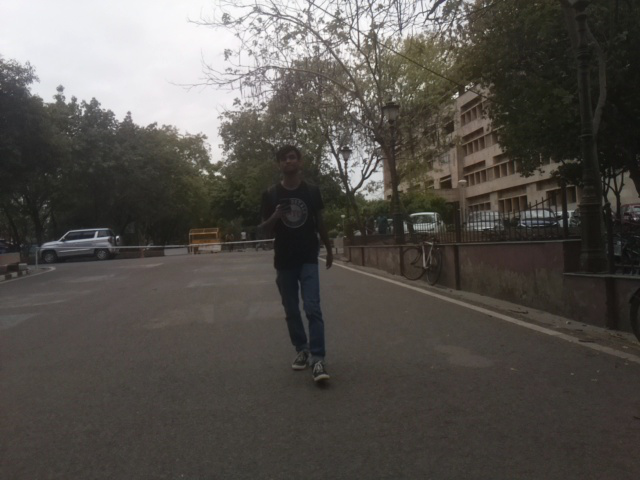

In [108]:
b

# feed forward

In [109]:
ans = model.predict(alp[0])

<p>ans will be of size (B,N,5)<p>
first four for regression of anchors and last one for classification score

In [110]:
bbox = ans[0][0]
scores= ans[1][0]
indices = ans[2][0][:,0]

In [111]:
bboxes = np.take(bbox,indices,axis=0)
scores = np.take(scores,indices,axis=0)

In [112]:
box2 = bboxes
scores2 = scores

## Applying Post-Processing

In [113]:
box2.shape
print(scores2.shape)

(5,)


In [114]:
scores2

array([0.8255404 , 0.10709795, 0.07971114, 0.07930118, 0.0668956 ],
      dtype=float32)

In [115]:
img = alp[0][0]
print(img.shape)

(480, 640, 3)


In [116]:
# ## Our GroundTruth Blue
# for i in range(len(gtbox)):
#     start = (int(gtbox[i][0]),int(gtbox[i][1]))
#     end = (int(gtbox[i][0])+int(gtbox[i][2]),int(gtbox[i][1])+int(gtbox[i][3]))
#     img = cv2.rectangle(img,start,end,(0,0,255),4)

In [117]:
## Our Predictions Red
l = box2.shape[0]
l = 1
for i in range(l):
    start = (int(box2[i][0]),int(box2[i][1]))
    end = (int(box2[i][2]),int(box2[i][3]))
#     print(start)
#     print(end)
    img = cv2.rectangle(img,start,end,(255,0,0),2)
#     break

In [98]:
anchors = Anchors.generate_anchors_from_input_shape((480,640),anchors_cfg)

In [101]:
# Candidates Green
for i in range(candidate_box.shape[0]):
    if candidate_box[i][-1]==1:
        box2 = anchors[i] + candidate_box[i][:4]
        start = (int(box2[0]),int(box2[1]))
        end = (int(box2[2]),int(box2[3]))
        img = cv2.rectangle(img,start,end,(0,255,0),2)
# for i in range(anchors.shape[0]):
# #     if candidate_box[i][-1]==1:
#     box2 = anchors[i]
#     start = (int(box2[0]),int(box2[1]))
#     end = (int(box2[2]),int(box2[3]))
#     img = cv2.rectangle(img,start,end,(255,255,0),2)
# #         print(candidate_box[i])

In [118]:
b = Image.fromarray(img.astype('uint8'))

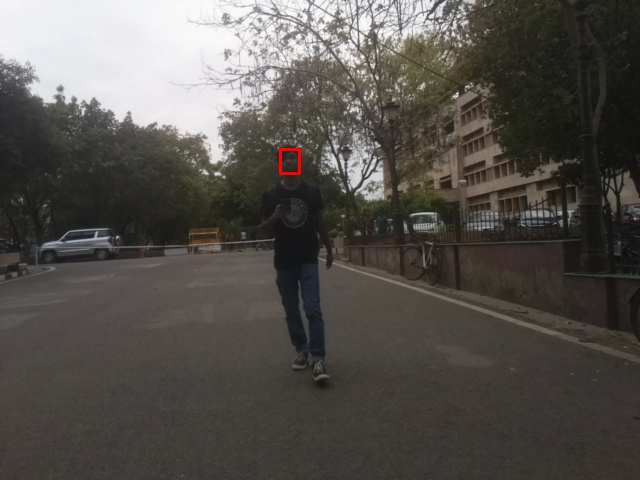

In [119]:
b

In [30]:
box2[0]

array([ 51.65295, 335.66272,  76.87154, 369.94247], dtype=float32)

In [32]:
img.shape

(480, 640, 3)